In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap
import joblib

%matplotlib inline
plt.style.use('default')

In [66]:
try:
    df = pd.read_csv("Electric_Vehicle_Population_Data.csv")  # Fixed filename
    print(f"Dataset loaded successfully! Shape: {df.shape}")
except FileNotFoundError:
    print("CSV file not found. Please make sure 'Electric_Vehicle_Population_Data.csv' is in your working directory.")
    print("You can check your current directory with: import os; print(os.getcwd())")

    print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully! Shape: (49, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 17 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   VIN (1-10)                                         49 non-null     object
 1   County                                             49 non-null     object
 2   City                                               49 non-null     object
 3   State                                              49 non-null     object
 4   Postal Code                                        49 non-null     int64 
 5   Model Year                                         49 non-null     int64 
 6   Make                                               49 non-null     object
 7   Model                                              49 non-null     object
 8   Electric Vehicle Type                              49 non

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,1N4BZ0CP5G,King,Seattle,WA,98125,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,46,349455557,POINT (-122.30253 47.72656),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033000202
1,KNDJX3AEXG,King,Renton,WA,98058,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93,31950,11,210641315,POINT (-122.08747 47.4466),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033025804
2,5YJ3E1EB2J,King,Seattle,WA,98115,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,43,171417494,POINT (-122.31676 47.68156),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033002600
3,1C4RJXN64R,Kitsap,Bremerton,WA,98312,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,0,26,262542927,POINT (-122.65223 47.57192),PUGET SOUND ENERGY INC,53035080600
4,5YJ3E1EB1J,Thurston,Olympia,WA,98512,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,35,110432815,POINT (-122.9131 47.01359),PUGET SOUND ENERGY INC,53067011810


In [67]:
print("\nOriginal columns:")
print(df.columns.tolist())

cols_to_drop = [
    'VIN (1-10)', 'Postal Code', 'DOL Vehicle ID', 'Vehicle Location',
    '2020 Census Tract', 'Legislative District'
]

existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
print(f"\nColumns to drop: {existing_cols_to_drop}")

df = df.drop(columns=existing_cols_to_drop)

required_cols = ['Electric Range', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"Warning: Missing required columns: {missing_cols}")
    print("Available columns:", df.columns.tolist())
else:
    print("All required columns found!")

print(f"\nShape before dropping NAs: {df.shape}")
df = df.dropna(subset=['Electric Range', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type'])
print(f"Shape after dropping NAs: {df.shape}")

print("\nRemaining columns:")
print(df.columns.tolist())


Original columns:
['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']

Columns to drop: ['VIN (1-10)', 'Postal Code', 'DOL Vehicle ID', 'Vehicle Location', '2020 Census Tract', 'Legislative District']
All required columns found!

Shape before dropping NAs: (49, 11)
Shape after dropping NAs: (49, 11)

Remaining columns:
['County', 'City', 'State', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Electric Utility']



Basic statistics for Electric Range:
count     49.000000
mean     139.551020
std       96.235402
min        0.000000
25%       39.000000
50%      153.000000
75%      220.000000
max      291.000000
Name: Electric Range, dtype: float64


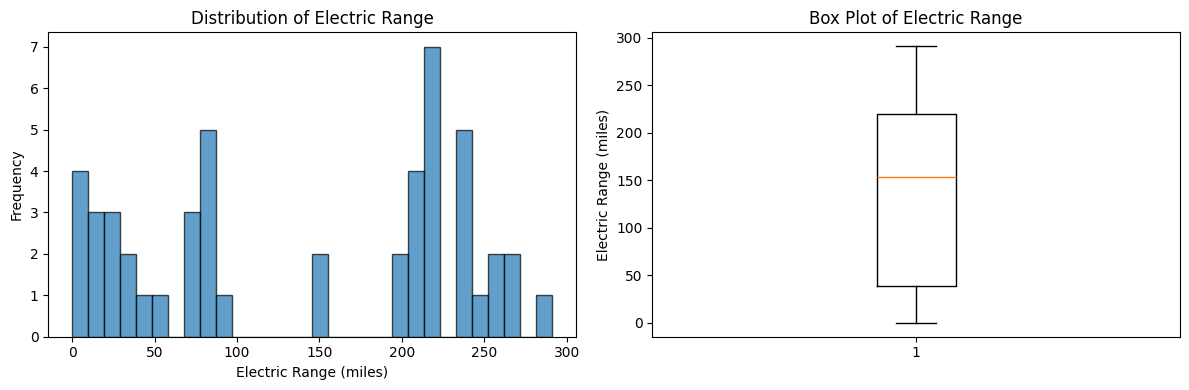

In [68]:
print("\nBasic statistics for Electric Range:")
print(df['Electric Range'].describe())

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['Electric Range'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Electric Range')
plt.xlabel('Electric Range (miles)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df['Electric Range'])
plt.title('Box Plot of Electric Range')
plt.ylabel('Electric Range (miles)')

plt.tight_layout()
plt.show()

In [69]:
potential_categorical_cols = ['County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type',
                             'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Utility']

categorical_cols = [col for col in potential_categorical_cols if col in df.columns]
print(f"\nCategorical columns found: {categorical_cols}")

for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count > 50:
        print(f"  Warning: {col} has many unique values - consider grouping or dropping")

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(f"\nShape after encoding: {df_encoded.shape}")

X = df_encoded.drop(columns=['Electric Range'])
y = df_encoded['Electric Range']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Categorical columns found: ['County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Utility']
County: 5 unique values
City: 28 unique values
State: 1 unique values
Make: 15 unique values
Model: 23 unique values
Electric Vehicle Type: 2 unique values
Clean Alternative Fuel Vehicle (CAFV) Eligibility: 3 unique values
Electric Utility: 4 unique values

Shape after encoding: (49, 76)
Features shape: (49, 75)
Target shape: (49,)


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

X_full = pd.concat([X_train, X_test], axis=0)

X_full_encoded = pd.get_dummies(X_full)

X_train_encoded = X_full_encoded.iloc[:len(X_train), :]
X_test_encoded = X_full_encoded.iloc[len(X_train):, :]

X_train_encoded = X_train_encoded.fillna(0).astype('float64')
X_test_encoded = X_test_encoded.fillna(0).astype('float64')




Training set: (39, 75)
Test set: (10, 75)


C:\Users\AERO\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


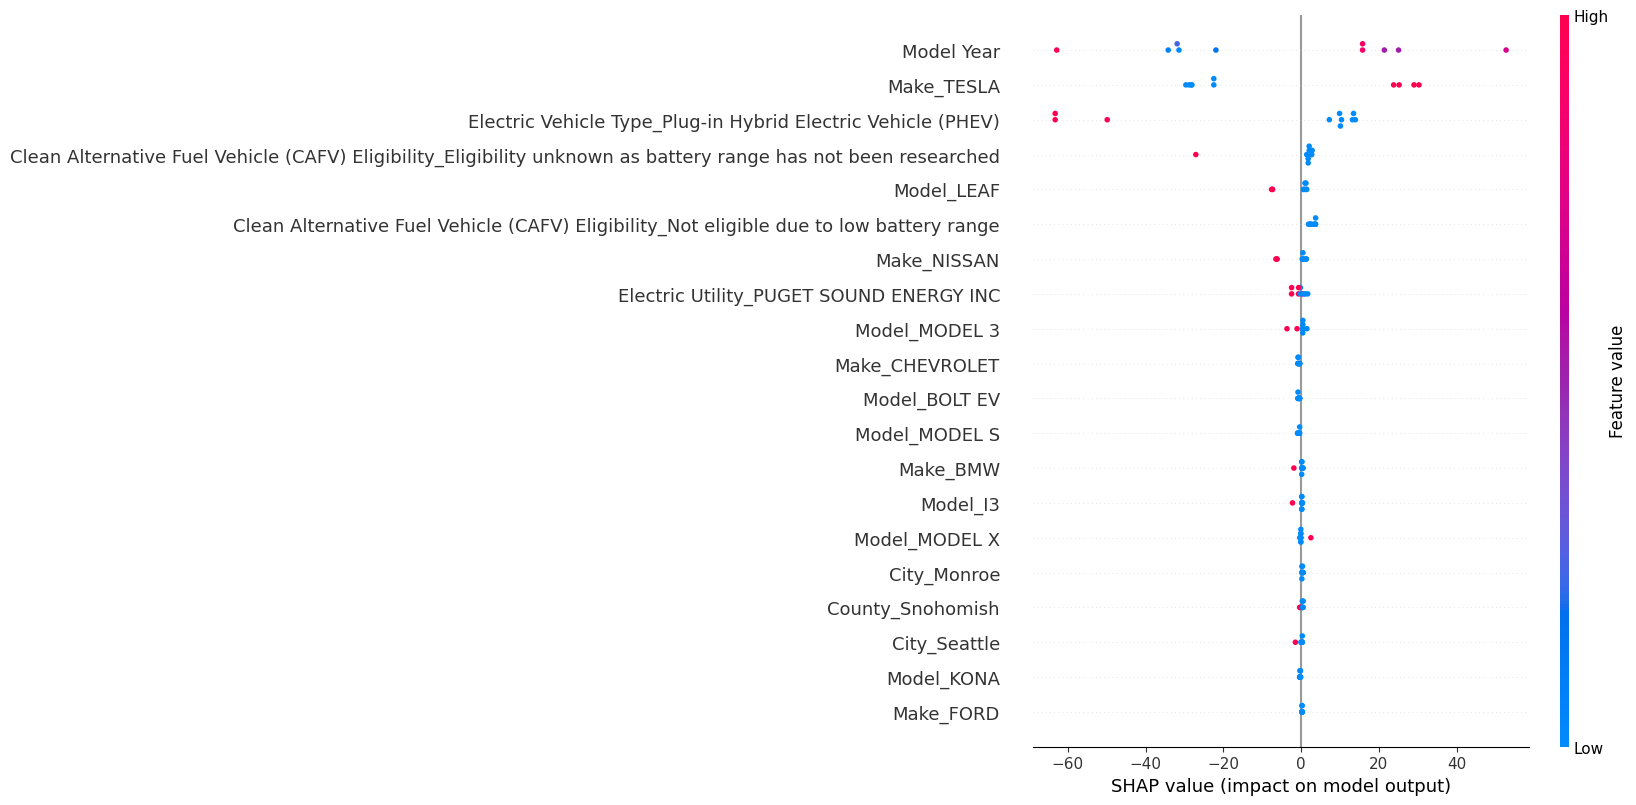

In [76]:
explainer = shap.Explainer(rf, X_train_encoded)
shap_values = explainer(X_test_encoded)
shap.summary_plot(shap_values, X_test_encoded)


Linear Regression Results:
  MAE: 63.9103
  RMSE: 91.0211
  R2: -0.0265

Random Forest Results:
  MAE: 29.0920
  RMSE: 41.5078
  R2: 0.7865


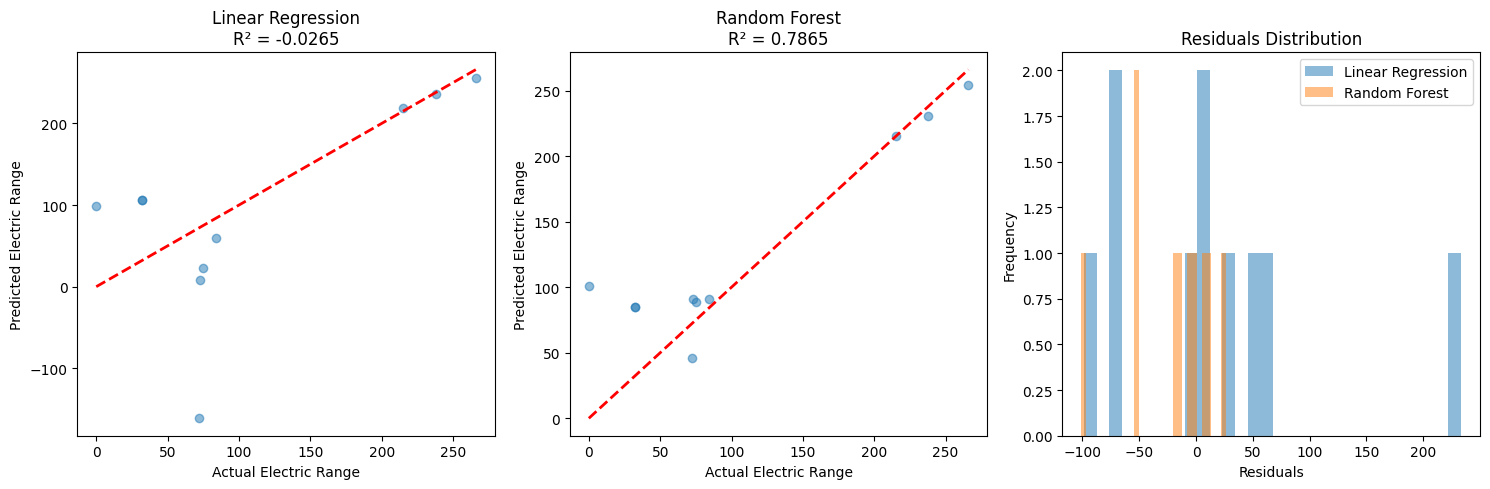

In [61]:
def eval_model(y_true, y_pred, model_name):
    metrics = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }
    print(f"\n{model_name} Results:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    return metrics

y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

lr_metrics = eval_model(y_test, y_pred_lr, "Linear Regression")
rf_metrics = eval_model(y_test, y_pred_rf, "Random Forest")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Electric Range')
plt.ylabel('Predicted Electric Range')
plt.title(f'Linear Regression\nR² = {lr_metrics["R2"]:.4f}')

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Electric Range')
plt.ylabel('Predicted Electric Range')
plt.title(f'Random Forest\nR² = {rf_metrics["R2"]:.4f}')

plt.subplot(1, 3, 3)
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf
plt.hist(residuals_lr, alpha=0.5, label='Linear Regression', bins=30)
plt.hist(residuals_rf, alpha=0.5, label='Random Forest', bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()

plt.tight_layout()
plt.show()


Top 10 Most Important Features:
                                              feature  importance
0                                          Model Year    0.333582
69  Electric Vehicle Type_Plug-in Hybrid Electric ...    0.198608
45                                         Make_TESLA    0.196144
71  Clean Alternative Fuel Vehicle (CAFV) Eligibil...    0.045925
70  Clean Alternative Fuel Vehicle (CAFV) Eligibil...    0.038301
34                                     Make_CHEVROLET    0.019284
41                                        Make_NISSAN    0.013208
73            Electric Utility_PUGET SOUND ENERGY INC    0.012764
56                                         Model_LEAF    0.011770
48                                      Model_BOLT EV    0.010996


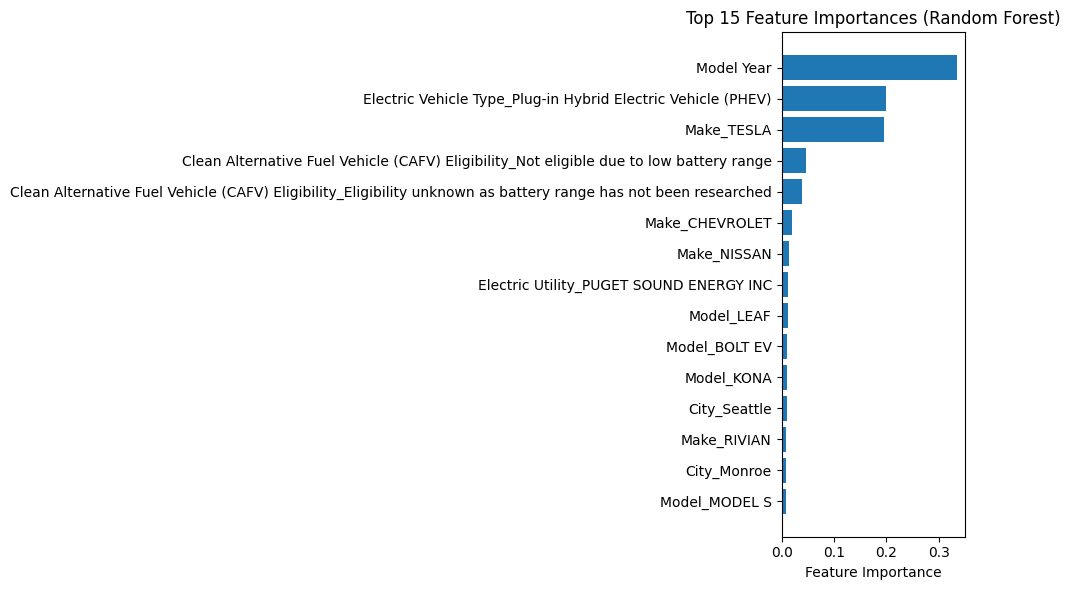

In [62]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [63]:
try:
    print("\nGenerating SHAP explanations...")
    sample_size = min(1000, len(X_test))
    X_sample = X_test.sample(n=sample_size, random_state=42)
    
    explainer = shap.Explainer(rf, X_train.sample(n=min(1000, len(X_train)), random_state=42))
    shap_values = explainer(X_sample)
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.tight_layout()
    plt.show()
    
    if 'Model Year' in X_sample.columns:
        plt.figure(figsize=(8, 6))
        shap.dependence_plot("Model Year", shap_values.values, X_sample, show=False)
        plt.tight_layout()
        plt.show()
    
except Exception as e:
    print(f"SHAP analysis failed: {e}")
    print("You may need to install SHAP: pip install shap")


Generating SHAP explanations...
SHAP analysis failed: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'
You may need to install SHAP: pip install shap


In [64]:
try:
    if 'rf_metrics' in locals() and 'lr_metrics' in locals():
        best_model = rf if rf_metrics['R2'] > lr_metrics['R2'] else lr
        model_name = "Random Forest" if rf_metrics['R2'] > lr_metrics['R2'] else "Linear Regression"
        best_r2 = max(rf_metrics['R2'], lr_metrics['R2'])
    else:
        best_model = rf
        model_name = "Random Forest"
        best_r2 = "N/A"
    
    joblib.dump(best_model, "best_ev_range_model.joblib")
    joblib.dump(X.columns.tolist(), "feature_columns.joblib")  # Save feature names
    
    print(f"\n Best model ({model_name}) saved as 'best_ev_range_model.joblib'")
    print(" Feature columns saved as 'feature_columns.joblib'")
    
except Exception as e:
    print(f"Error saving model: {e}")

print("\n Analysis complete:")

try:
    if 'rf_metrics' in locals() and 'lr_metrics' in locals():
        best_model_name = 'Random Forest' if rf_metrics['R2'] > lr_metrics['R2'] else 'Linear Regression'
        best_score = max(rf_metrics['R2'], lr_metrics['R2'])
        print(f"Best model: {best_model_name}")
        print(f"Best R² score: {best_score:.4f}")
        
        print(f"\nModel Comparison:")
        print(f"  Linear Regression R²: {lr_metrics['R2']:.4f}")
        print(f"  Random Forest R²: {rf_metrics['R2']:.4f}")
    else:
        print("Model evaluation metrics not available")
        print("Models were trained but evaluation may have failed")
        
except Exception as e:
    print(f"Error in final summary: {e}")


✓ Best model (Random Forest) saved as 'best_ev_range_model.joblib'
✓ Feature columns saved as 'feature_columns.joblib'

🎉 Analysis complete!
Best model: Random Forest
Best R² score: 0.7865

Model Comparison:
  Linear Regression R²: -0.0265
  Random Forest R²: 0.7865
